# Plot exploded tree with case counts 

August 15, 2019 

To better visualize the introductions of mumps into Washington, I would like to plot an exploded tree view of the full North American tree, with Washington and Arkansas case counts plotted below. This code will produce that exploded tree, as well as the exploded trees in which Washington tips are colored by metadata, like community status and vaccination status.  

In [1]:
import sys, subprocess, glob, os, shutil, re, importlib
from subprocess import call
import imp
bt = imp.load_source('baltic', '../../baltic/baltic/baltic.py')

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patheffects as path_effects
import matplotlib.lines as mlines
from matplotlib.font_manager import FontProperties
import matplotlib.colors as clr
from matplotlib import rc
import textwrap as textwrap
from textwrap import wrap

import numpy as np
from scipy.special import binom

import sys, subprocess, glob, os, shutil, re, importlib, Bio, csv
from subprocess import call
from Bio import SeqIO
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import rpy2
import seaborn as sns
%load_ext rpy2.ipython

import datetime
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from datetime import datetime
from dateutil.parser import parse

## Read in metadata

In [2]:
def read_metadata(metadata_path):
    metadata = {}
    
    with open(metadata_path, "r") as infile: 
        for line in infile: 
            if "strain_name" not in line: # skip first line
                strain_name = line.split("\t")[0].replace("MuVs/","").replace("[","/").replace("]","")
                ID = line.split("\t")[1]
                age = line.split("\t")[3]
                vaccination_status = line.split("\t")[4].lower()                    
                community_status = line.split("\t")[5]
                
                # add age category 
                if int(age) < 18:
                    age_category = "< 18"
                elif int(age) >= 18 and int(age) < 30:
                    age_category = "18-30"
                else:
                    age_category = "> 30"

                
                metadata[strain_name] = {}
                metadata[strain_name]['age'] = age
                metadata[strain_name]['age_category'] = age_category
                metadata[strain_name]['vaccination_status'] = vaccination_status
                metadata[strain_name]['community_status'] = community_status
                
    return(metadata)

# Read in WA and AR case count data and plot 

In [3]:
AR_case_counts = "/Users/lmoncla/Documents/Mumps/Arkansas/Arkansas-case-counts.txt"
WA_case_counts = "/Users/lmoncla/Documents/Mumps/samples/WA-16-18casecounts_onset.txt"
metadata_path = "../../sample-metadata-complete-2020-10-06.txt"

genomes = "/Users/lmoncla/src/mumps/data/mumps.fasta"

### Read in Washington genomes

1. count the number of genomes per week
2. Convert to a dataframe

In [4]:
# read in sequences and parse by epi week 
def count_samples_per_epiweek(genomes, metadata):

    samples_per_epiweek = {2016:{}, 2017:{}, 2018:{}}

    for seq in SeqIO.parse(genomes, "fasta"):
        if "Fred_Hutch_seq" in seq.id and "washington" in seq.id:
            strain = seq.id.split("|")[0]
            epiweek= strain.split("/")[1]
            sample = strain.split("/")[2]
            
            year = int("20" + epiweek.split(".")[1])
            week = int(epiweek.split(".")[0])

            # call in R to convert the epiweek and year to a calendar date for plotting using the MMWRweek package
            %R require(MMWRweek); library(MMWRweek)
            %R -i year,week
            %R cal_date = MMWRweek2Date(year,week)
            %R -o cal_date
            calendar_date = str(cal_date).replace("[1] ","").replace("\"","").strip()

            Marshallese = metadata[strain]['community_status']
            if Marshallese == "Micronesian":
                Marshallese = "Not_Marshallese"

            # add rows with 0 values for weeks with no samples 
            if week not in samples_per_epiweek[year]:
                samples_per_epiweek[year][week] = {"Marshallese":0, "Not_Marshallese":0, "Unknown":0, "calendar_date":calendar_date}
                samples_per_epiweek[year][week][Marshallese] += 1

            else:
                samples_per_epiweek[year][week][Marshallese] += 1

    return(samples_per_epiweek)

In [5]:
metadata = read_metadata(metadata_path)
samples_per_epiweek = count_samples_per_epiweek(genomes, metadata)
print(samples_per_epiweek)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: MMWRweek

  warnings.warn(x, RRuntimeWarning)


{2016: {52: {'Marshallese': 2, 'Not_Marshallese': 0, 'Unknown': 0, 'calendar_date': '2016-12-25'}, 51: {'Marshallese': 1, 'Not_Marshallese': 1, 'Unknown': 0, 'calendar_date': '2016-12-18'}, 49: {'Marshallese': 0, 'Not_Marshallese': 3, 'Unknown': 0, 'calendar_date': '2016-12-04'}, 48: {'Marshallese': 1, 'Not_Marshallese': 0, 'Unknown': 0, 'calendar_date': '2016-11-27'}, 50: {'Marshallese': 3, 'Not_Marshallese': 2, 'Unknown': 0, 'calendar_date': '2016-12-11'}}, 2017: {10: {'Marshallese': 2, 'Not_Marshallese': 0, 'Unknown': 0, 'calendar_date': '2017-03-05'}, 12: {'Marshallese': 3, 'Not_Marshallese': 4, 'Unknown': 0, 'calendar_date': '2017-03-19'}, 2: {'Marshallese': 8, 'Not_Marshallese': 1, 'Unknown': 0, 'calendar_date': '2017-01-08'}, 29: {'Marshallese': 0, 'Not_Marshallese': 1, 'Unknown': 0, 'calendar_date': '2017-07-16'}, 5: {'Marshallese': 5, 'Not_Marshallese': 5, 'Unknown': 0, 'calendar_date': '2017-01-29'}, 19: {'Marshallese': 0, 'Not_Marshallese': 4, 'Unknown': 0, 'calendar_date': 

In [6]:
# convert to dataframe 
samples_df = pd.DataFrame()

for year in samples_per_epiweek:
    for epiweek in samples_per_epiweek[year]:
        if len(str(epiweek)) == 1:
            epiweek2 = "0" + str(epiweek)
        else:
            epiweek2 = epiweek
        to_add = {"year":[year], "epiweek":epiweek, "epiweek_3_letter":epiweek2,"calendar_date":samples_per_epiweek[year][epiweek]["calendar_date"],"Marshallese":samples_per_epiweek[year][epiweek]["Marshallese"], "Non_Marshallese":samples_per_epiweek[year][epiweek]["Not_Marshallese"]}
        d = pd.DataFrame.from_dict(to_add)
        samples_df = samples_df.append(d)

samples_df['samples_in_dataset'] = samples_df['Marshallese'] + samples_df['Non_Marshallese']
samples_df['CDC_Week'] = samples_df['year'].astype(str) + samples_df['epiweek_3_letter'].astype(str)

samples_df.head()

,year,epiweek,epiweek_3_letter,calendar_date,Marshallese,Non_Marshallese,samples_in_dataset,CDC_Week
0,2016,52,52,2016-12-25,2,0,2,201652
0,2016,51,51,2016-12-18,1,1,2,201651
0,2016,49,49,2016-12-04,0,3,3,201649
0,2016,48,48,2016-11-27,1,0,1,201648
0,2016,50,50,2016-12-11,3,2,5,201650


In [7]:
# reformat dataframe so that each row represents 1 sample 
samples_df2 = pd.DataFrame()

for index, row in samples_df.iterrows():
    year = row['year']
    epiweek = row['epiweek']
    epiweek_3_letter = row['epiweek_3_letter']
    calendar_date = row['calendar_date']
    Marshallese = row['Marshallese']
    Non_Marshallese = row['Non_Marshallese']
    CDC_week = row['CDC_Week']
    
    M = pd.DataFrame()
    for i in range(Marshallese):
        x = {"year":[year],"epiweek":[epiweek],"epiweek_3_letter":[epiweek_3_letter],
             "calendar_date":[calendar_date],"Marshallese":[1],"Non_Marshallese":[0],
             "CDC_week":[CDC_week]}
        d1 = pd.DataFrame.from_dict(x)
        
        M = M.append(d1)
    
    N = pd.DataFrame()
    for i in range(Non_Marshallese):
        x = {"year":[year],"epiweek":[epiweek],"epiweek_3_letter":[epiweek_3_letter],
             "calendar_date":[calendar_date],"Marshallese":[0],"Non_Marshallese":[1],
             "CDC_week":[CDC_week]}
        d2 = pd.DataFrame.from_dict(x)
        
        N = N.append(d2)
        
    samples_df2 = samples_df2.append(M)
    samples_df2 = samples_df2.append(N)

samples_df2.reset_index(inplace=True)

In [8]:
samples_df2['total_WA_genomes'] = samples_df2['Marshallese'] + samples_df2["Non_Marshallese"]
samples_df2 = samples_df2.replace(0, np.nan)
samples_df2.head()

,index,year,epiweek,epiweek_3_letter,calendar_date,Marshallese,Non_Marshallese,CDC_week,total_WA_genomes
0,NaN,2016,52,52,2016-12-25,1.0,NaN,201652,1
1,NaN,2016,52,52,2016-12-25,1.0,NaN,201652,1
2,NaN,2016,51,51,2016-12-18,1.0,NaN,201651,1
3,NaN,2016,51,51,2016-12-18,NaN,1.0,201651,1
4,NaN,2016,49,49,2016-12-04,NaN,1.0,201649,1


### Read in Arkansas case counts and format into a dictionary 

One note about the Arkansas case count dates: the MMWR epiweek begins on a Sunday, but the AR-DOH seems to have done their testing on every Monday. So the calendar dates in the file reflect the actual date that the number of cases for that week was reported, but is not the start of the epiweek. The epiweek information in the file just refers to the epiweek that the test date falls within. So, because I need the time intervals to be the same in each deme, I am going to use the epiweek information from Arkansas to determine the calendar date that is the start of the epiweek. 

In [9]:
AR_dict = {}

with open(AR_case_counts, "r") as infile: 
     for line in infile: 
        if "Race/Ethnicity and Case Classification" in line: 
            for i in range(1,len(line.split("\t"))):
                date = line.split("\t")[i].strip()
                year = date.split(" ")[0]
                epiweek = date.split(" ")[1]
                
                year = int(year)
                epiweek = int(epiweek)
                # call in R to convert the epiweek and year to a calendar date for plotting using the MMWRweek package
                %R require(MMWRweek); library(MMWRweek)
                %R -i year,epiweek
                %R cal_date = MMWRweek2Date(year,epiweek)
                %R -o cal_date
                calendar_date = str(cal_date).replace("[1] ","").replace("\"","").strip()

                AR_dict[i] = {"year":year, "epiweek":epiweek, "calendar_date":calendar_date}
        
        if "Confirmed" in line: 
            for i in range(1,len(line.split("\t"))):
                confirmed = line.split("\t")[i].strip()
                confirmed = int(confirmed)
                AR_dict[i]["confirmed"] = confirmed
        if "Probable" in line: 
            for i in range(1,len(line.split("\t"))):
                probable = line.split("\t")[i].strip()
                probable = int(probable)
                AR_dict[i]["probable"] = probable
        

#AR_dict           

### Read in Washington case counts and format into a dataframe

In [10]:
WA_dict = {}
count = 0

with open(WA_case_counts, "r") as infile: 
    for line in infile:
        count += 1
        if "CDC_Week" not in line: 
            date = line.split("\t")[0]
            year = date[0:4]
            epiweek = date[4:]
            marshallese = line.split("\t")[4]
            marshallese = int(marshallese)
            nonmarshallese = line.split("\t")[5]
            nonmarshallese = int(nonmarshallese)
            unknown = line.split("\t")[6]
            unknown = int(unknown)
            
            year = int(year)
            epiweek = int(epiweek)
            # call in R to convert the epiweek and year to a calendar date for plotting using the MMWRweek package
            %R require(MMWRweek); library(MMWRweek)
            %R -i year,epiweek
            %R cal_date = MMWRweek2Date(year,epiweek)
            %R -o cal_date
            calendar_date = str(cal_date).replace("[1] ","").replace("\"","").strip()
            
            WA_dict[count] = {"calendar_date":calendar_date, "year":year, "epiweek":epiweek, "marshallese":marshallese,
                             "nonmarshallese":nonmarshallese, "unknown":unknown}
            
#WA_dict

In [11]:
def convert_decimal_date_to_calendar_date(date):
    
    month_conversion_dictionary = {"01":"Jan","02":"Feb","03":"Mar","04":"Apr","05":"May","06":"Jun",
                                   "07":"Jul","08":"Aug","09":"Sep","10":"Oct","11":"Nov",
                                   "12":"Dec"}
#     month_conversion_dictionary = {"01":"January","02":"February","03":"March","04":"April","05":"May","06":"June",
#                                    "07":"July","08":"August","09":"September","10":"October","11":"November",
#                                    "12":"December"}
    
    # call in R to convert collection date to decimal date and store as a new variable
    %R require(lubridate); library(lubridate)
    %R -i date
    %R cal_date = date_decimal(date)
    %R -o cal_date
    calendar_date = str(cal_date).split(" ")[1].replace("\"","")
    year = calendar_date.split("-")[0]
    month = calendar_date.split("-")[1]
    day = calendar_date.split("-")[2]
    
    text_month = month_conversion_dictionary[month]

    
    text_date = text_month + " " + day.replace("0","") + " " + year
        
    return(text_date)

In [12]:
def convert_calendar_date_to_decimal_date(dictionary):
    for i in dictionary:
        date = dictionary[i]['calendar_date']
    
        # call in R to convert collection date to decimal date and store as a new variable
        %R require(lubridate); library(lubridate)
        %R -i date
        %R dateR <- ymd(date)
        %R dec_date = decimal_date(dateR)
        %R -o dec_date
        decimal_date = str(dec_date).replace("[1] ","").strip()
        
        decimal_date = float(decimal_date)
        dictionary[i]['decimal_date'] = decimal_date

In [13]:
convert_calendar_date_to_decimal_date(WA_dict)
convert_calendar_date_to_decimal_date(AR_dict)

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Loading required package: lubridate

  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 
Attaching package: ‘lubridate’


  warnings.warn(x, RRuntimeWarning)
/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: The following object is masked from ‘package:base’:

    date


  warnings.warn(x, RRuntimeWarning)


In [14]:
#AR_dict

In [15]:
AR_df = pd.DataFrame.from_dict(AR_dict, orient="index")
AR_df["total"] = AR_df['confirmed'] + AR_df['probable']
AR_df.head()

,year,epiweek,calendar_date,confirmed,probable,decimal_date,total
1,2016,32,2016-08-07,1,0,2016.598,1
2,2016,33,2016-08-14,0,0,2016.617,0
3,2016,34,2016-08-21,0,0,2016.637,0
4,2016,35,2016-08-28,14,11,2016.656,25
5,2016,36,2016-09-04,10,11,2016.675,21


In [16]:
WA_df = pd.DataFrame.from_dict(WA_dict, orient="index")
WA_df["total"] = WA_df['marshallese'] + WA_df['nonmarshallese'] + WA_df['unknown']
WA_df.head()

,calendar_date,year,epiweek,marshallese,nonmarshallese,unknown,decimal_date,total
2,2016-10-30,2016,44,3,0,0,2016.828,3
3,2016-11-06,2016,45,2,3,0,2016.847,5
4,2016-11-13,2016,46,4,3,0,2016.866,7
5,2016-11-20,2016,47,5,5,0,2016.885,10
6,2016-11-27,2016,48,8,10,0,2016.904,18


### Merge, sort and fill in dataframes

The lastest date for our sequences is July 26, 2017, which falls within 2017 epiweek 30, and has a decimal date of 2017.556. I will merge the WA and AR case counts together, and then remove all case counts after epiweek 30. 

In [17]:
# merge dataframes together
merged_cases = AR_df.merge(WA_df, on=['calendar_date','year','epiweek','decimal_date'], how="outer")
merged_cases.columns = ['year','epiweek','calendar_date','confirmed_cases_AR','probable_cases_AR','decimal_date','total_AR','Marshallese_cases_WA','NonMarshallese_cases_WA','unknown_cases_WA','total_WA']
merged_cases = merged_cases.fillna(0)
merged_cases.head()

,year,epiweek,calendar_date,confirmed_cases_AR,probable_cases_AR,decimal_date,total_AR,Marshallese_cases_WA,NonMarshallese_cases_WA,unknown_cases_WA,total_WA
0,2016,32,2016-08-07,1.0,0.0,2016.598,1.0,0.0,0.0,0.0,0.0
1,2016,33,2016-08-14,0.0,0.0,2016.617,0.0,0.0,0.0,0.0,0.0
2,2016,34,2016-08-21,0.0,0.0,2016.637,0.0,0.0,0.0,0.0,0.0
3,2016,35,2016-08-28,14.0,11.0,2016.656,25.0,0.0,0.0,0.0,0.0
4,2016,36,2016-09-04,10.0,11.0,2016.675,21.0,0.0,0.0,0.0,0.0


In [18]:
merged_cases['calendar_date'] =  pd.to_datetime(merged_cases['calendar_date'], format='%Y-%m-%d')

# Plot exploded tree by geographic division

### Parse leaf and node information into a dictionary 

Write out the node probabilities for division to a dictionary and read in divisions for tips. 

In [19]:
def parse_leaf_and_node_traits(tree):
    # parse leaf and node information into a dictionary for plotting
    metadata = {}
    node_types = {}
    node_probs = {}

    for k in tree.Objects: ## iterate over objects in tree
        if isinstance(k, bt.leaf) == True or k.branchType=='leaf':
            division = k.traits['geo']
            metadata[k] = {}
            metadata[k]["division"] = division

        # parse the nodes now and pick out the type trait
        if isinstance(k, bt.node) == True or k.branchType=='node':
            node_division = k.traits["geo"]
            node_types[k] = {}
            node_types[k]["division"] = node_division
            prob_node_division = k.traits["geo.prob"]
            node_probs[k] = {}
            node_probs[k] = prob_node_division
    
    return(metadata,node_types,node_probs)

### Enumerate subtrees 

This uses the subtrees feature of baltic to identify transitions between geographic states. Once there has been a transition, enumerate the total subtending tree from that transition. 

In [20]:
def enumerate_subtrees(tree):
    
    traitName="geo"

    tree.root.traits[traitName]='ancestor' ## give root node some trait value that's different from what the actual tree root has, so it registers as a switch

    tree_strings={division:[] for division in division_order}
    subtype_trees={division:[] for division in division_order}

    for k in sorted(tree.Objects,key=lambda x:x.height):
        kp=k.parent     # kp is the parent node of k

        ## get current node's (k) and its parent's (kp) trait states
        kloc=k.traits[traitName]      # kloc = trait of k; kc = trait of k; they are the same thing
        if traitName in k.parent.traits:       # if parent has a trait block, use that trait, else assign to ancestor
            kploc=kp.traits[traitName]              # kploc = trait of parental node
        else:
            kploc='ancestor'

        kc=kloc     
        ## if states do not match
        if kloc!=kploc:      # if node and parental node do not have the same trait
            #N_children=len(k.leaves)
            traverse_condition=lambda w:w.traits[traitName]==kloc     # traverse tree for all nodes whose traitname = kc
            #print('subtree resulting from %s>%s switch, traversing within %s'%(kploc,kloc,kloc))
            subtree=tree.subtree(k,traverse_condition=traverse_condition) #traitName = traitName ## this function returns a new baltic object that contains a trait-traversed subtree, starting from node k, for as long as the traversal stays within the starting trait value state

            if subtree != None:
                subtree.traverse_tree()
                subtree.sortBranches()
                tree_strings[kloc].append(subtree.toString()) ## remember subtree string, subtree object itself
                subtype_trees[kloc].append((kploc,subtree))
    
    return(subtype_trees)

### Manually sort for plotting 

I want to group all non-Arkansas introductions together at the top of the plot, while leaving Arkansas introductions grouped together at the bottom. The code below puts the subtrees in the order I want them to be in for plotting. 

In [66]:
def split_subtrees_into_plotting_groups(subtype_trees):
    
    group1 = {}
    group2 = {}

    for s in subtype_trees['washington']:
        origen = s[0]
        loc_tree = s[1]
        oriX=loc_tree.root.absoluteTime

        # if you either have a very old TMRCA or you aren't from Arkansas
        # this needs to be a dictionary with a list inside it in case 2 intros have the exact same oriX
        if oriX < 2001 or origen != 'arkansas':
            if oriX in group1:
                group1[oriX].append(s)
            else:
                group1[oriX] = [s]

        # if you are recent and from Arkansas
        else:
            if oriX in group2:
                group2[oriX].append(s)
            else:
                group2[oriX] = [s]
    
    return(group1,group2)

In [67]:
def order_subtrees_for_plotting(group1,group2):
    
    subtype_trees2 = {}
    subtype_trees2['washington'] = []
    
    # sort by origin from oldest to newest
    for i in sorted(group1.keys()):
        for subtree in group1[i]:
            subtype_trees2['washington'].append(subtree)
    
    for i in sorted(group2.keys()):
        for subtree in group2[i]:
            subtype_trees2['washington'].append(subtree)
    
    return(subtype_trees2)

In [102]:
def plot_exploded_tree(subtype_trees2, filename, cutoff_value, lower_x_limit, dates_dict, width, height):
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,((ax1),(ax2)) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1], 'hspace':0.01}, figsize=(width, height),facecolor='w')

    axes = [ax1,ax2]

    traitName='geo'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = cutoff_value
    origin_size=125

    # this sets the vertical dashed lines on the tree
    dates = []
    date_labels = []
    for i in np.arange(lower_x_limit, 2018, 0.25): 
        dates.append(i)
        date_labels.append(dates_dict[i]['label'])
    [ax1.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.3) for i in dates]
    branchWidth=1.75 ## default branch width

    for subtree in reversed(subtype_trees2['washington']): ## iterate over trait values
        origin = subtree[0]
        loc_tree = subtree[1]
        min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
        
        """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
        for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
        for k in loc_tree.Objects:
            
            xp=k.parent.absoluteTime
            x = k.absoluteTime
            y = k.y + cumulative_y
            c = colors[k.traits[traitName]]
            s = tipSize
            a = k.traits["geo.prob"]
 
            if k.branchType == "leaf":
                ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)
                              
            elif k.branchType == "node": 
                # this plots the vertical lines connecting children and parents on tree
                ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
            
            if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
                if xp >= cutoff:
                    ax1.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
                else:
                    ax1.plot([xp,cutoff],[y,y],":",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines
                    ax1.plot([cutoff,x],[y,y],"-",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines

        """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
        that line be dotted or solid depending on how far back the origin is and how far back the node is"""
        # first, plot the origin circle
        oriC = colors[origin]
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
             
        # plot dotted line connecting circle to tree 
        if min_node_x < cutoff: # whole thing before cutoff, whole thing dotted
            ax1.plot([min_node_x,oriX],[oriY,oriY], ":", color=c,lw=branchWidth,zorder=98)

        elif oriX < cutoff: # partly before 2016, partial dotteds
            ax1.plot([min_node_x,cutoff],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
            ax1.plot([cutoff,oriX],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)

        else:
            ax1.plot([min_node_x,oriX],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
        
        # increment cumulative y displacement
        cumulative_y+=loc_tree.ySpan+5 

    #add in a legend
    han_list = []
    for key in colors_to_plot:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[-0.1, 0.12], loc=3, prop={'size': 16}, facecolor='w')

    ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(dates[0],dates[-1])
    ax1.set_xticks(dates)
    ax1.set_xticklabels(date_labels, fontsize=14)
    ax1.axes.get_xaxis().set_ticks([])
    
    
    """Plot case counts in a separate panel below the exploded tree"""
    
    dates2= []
    for d in dates: 
        string_date = dates_dict[d]['date']
        d2 = datetime.strptime(string_date, '%Y-%m-%d')
        dates2.append(d2)
    [ax2.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.5) for i in dates2]

    x = merged_cases['calendar_date']
    y1 = merged_cases['total_AR']
    y2 = merged_cases['total_WA']

    ax2.bar(x, y1, width=7, color=colors['arkansas'], edgecolor="black", bottom=y2)
    ax2.bar(x, y2, width=7, color=colors['washington'], edgecolor="black")
    ax2.xaxis_date()

    ax2.xaxis.tick_bottom()
    ax2.yaxis.tick_left()

    [ax2.spines[loc].set_visible(False) for loc in ['top','right']]

    ax2.set_xlim(str(dates2[0]),str(dates2[-1]))
    ax2.set_xticks(dates2[:-1])
    ax2.set_xticklabels(date_labels, fontsize=14)
    ax2.set_ylabel("cases\n", fontsize=14)
    ax2.set_yticks([0,50,100,150,200,250,300])
    ax2.set_yticklabels([0,"",100,"",200,"",300], fontsize=14)  
    
    plt.tight_layout()
    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [24]:
def plot_exploded_tree_no_cases(subtype_trees2, filename, cutoff_value, lower_x_limit, dates_dict, width, height):
    
    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rc('text', usetex='false') 
    mpl.rcParams.update({'font.size': 22})
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    traitName='geo'
    tipSize=20
    mpl.rcParams['font.size']=16
    cumulative_y=0
    cutoff = cutoff_value
    origin_size=150

    # this sets the vertical dashed lines on the tree
    dates = []
    date_labels = []
    for i in np.arange(lower_x_limit, 2017.6, (1/12)): 
        dates.append(i)
    for i in np.arange(lower_x_limit, 2018, 0.25): 
        date_labels.append(dates_dict[i]['label'])
    [ax1.axvline(i,ls='--',lw=1,color='grey',zorder=0, alpha=0.5) for i in dates]
    branchWidth=1.75 ## default branch width

    for subtree in reversed(subtype_trees2['washington']): ## iterate over trait values
        origin = subtree[0]
        loc_tree = subtree[1]
        min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
        
        # pull out the 95% HPD for each subtree's root
        for k in loc_tree.Objects:
            if k.absoluteTime == min_node_x:
                min_node = k
        min_node_hpd = min_node.traits['height_95%_HPD']
        
        # count number of total leaves
        number_tips = 0
        for k in loc_tree.Objects:
            if k.branchType == "leaf":
                number_tips += 1
        
        """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
        for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
        for k in loc_tree.Objects:
            
            xp=k.parent.absoluteTime
            x = k.absoluteTime
            y = k.y + cumulative_y
            c = colors[k.traits[traitName]]
            s = tipSize
            a = k.traits["geo.prob"]
 
            if k.branchType == "leaf":
                ax1.scatter(x,y,s=tipSize,facecolor=c, alpha=a,edgecolor="black",zorder=100) ## plot tip circle
                ax1.scatter(x,y,s=tipSize,facecolor="black", alpha=a,edgecolor="black",zorder=99)
                              
            elif k.branchType == "node": 
                # this plots the vertical lines connecting children and parents on tree
                ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,alpha=a,ls='-',zorder=9)            
            
            if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
                if xp >= cutoff:
                    ax1.plot([xp,x],[y,y],lw=branchWidth,color=c,ls='-',zorder=9)   # this connects horizontal tree lines
                else:
                    ax1.plot([xp,cutoff],[y,y],":",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines
                    ax1.plot([cutoff,x],[y,y],"-",lw=branchWidth,color=c,zorder=9)   # this connects horizontal tree lines

        """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
        that line be dotted or solid depending on how far back the origin is and how far back the node is"""
        # first, plot the origin circle
        oriC = colors[origin]
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
        
        # add in text for the TMRCA for primary outbreak clade
        calendar_date = convert_decimal_date_to_calendar_date(oriX)
        hpd_lower_date = convert_decimal_date_to_calendar_date(2018-min_node_hpd[0]).replace(" 2016","")
        hpd_upper_date = convert_decimal_date_to_calendar_date(2018-min_node_hpd[1]).replace(" 2016","")
        to_print = "    "+calendar_date + "\n(" + hpd_upper_date +", " + hpd_lower_date + ")"
        print(to_print)
        if number_tips > 50:
            ax1.text(oriX-0.15,oriY+6, to_print, fontsize=12)
        
        # plot dotted line connecting circle to tree 
        if min_node_x < cutoff: # whole thing before cutoff, whole thing dotted
            ax1.plot([min_node_x,oriX],[oriY,oriY], ":", color=c,lw=branchWidth,zorder=98)

        elif oriX < cutoff: # partly before 2016, partial dotteds
            ax1.plot([min_node_x,cutoff],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
            ax1.plot([cutoff,oriX],[oriY,oriY],":",color=c,lw=branchWidth,zorder=98)

        else:
            ax1.plot([min_node_x,oriX],[oriY,oriY],"-",color=c,lw=branchWidth,zorder=98)
        
        # increment cumulative y displacement
        cumulative_y+=loc_tree.ySpan+5 

    #add in a legend
    han_list = []
    for key in colors_to_plot:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[-0.1, 0.15], loc=3, prop={'size': 18}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)

    ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(dates[0],dates[-1])
    ax1.set_xticks(dates[::3])
    ax1.set_xticklabels(date_labels, fontsize=12)
    
    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

## Run it

In [25]:
dates_dict = {2015:{"label":"Jan\n2015", "date":"2015-01-01"}, 
             2015.25:{"label":"Apr\n2015", "date":"2015-04-01"},
             2015.5:{"label":"Jul\n2015", "date":"2015-07-01"},
             2015.75:{"label":"Oct\n2015", "date":"2015-10-01"},
             2016:{"label":"Jan\n2016", "date":"2016-01-01"}, 
             2016.25:{"label":"Apr\n2016", "date":"2016-04-01"},
             2016.5:{"label":"Jul\n2016", "date":"2016-07-01"},
             2016.75:{"label":"Oct\n2016", "date":"2016-10-01"},
             2017:{"label":"Jan\n2017", "date":"2017-01-01"}, 
             2017.25:{"label":"Apr\n2017", "date":"2017-04-01"},
             2017.5:{"label":"Jul\n2017", "date":"2017-07-01"},
             2017.75:{"label":"Oct\n2017", "date":"2017-10-01"}}

In [78]:
# blue orange
colors = {"arkansas":"#EEA160",
          "massachusetts":"#544370",
          "missouri":"#5CA7A4",
          "ontario":"#B2313D",
          "washington":"#2664A5",
         "ancestor":'grey'}

In [88]:
division_order = ["british_columbia","california","new_york","georgia","virginia","manitoba","washington",
                  "north_dakota","massachusetts","missouri","pennsylvania","texas","indiana","ohio","michigan",
                  "new_hampshire","arkansas",'iowa',"kansas","new_jersey","alabama",
                  "louisiana","ontario","montana","wisconsin","north_carolina","illinois"]  
colors_to_plot = ["ontario","arkansas","washington","missouri", "massachusetts"]

date = datetime.today().strftime('%Y-%m-%d')

cutoff_value = 2016.25
lower_x_limit = 2015.75 #2016.25

In [95]:
# set path to tree to load 

tree_path = "../beast/output/no-metadata/mumps-north-american-seqs-DTA-2020-12-10-exp-mean-26.mcc.tree"
offset = "-mean-26-"


output_file_directory = "/Users/lmoncla/Documents/Mumps/paper-and-figure-drafts/eLife-submission-2020-01-08/resubmission-2021-03/figures/individual-PDFs/"
exploded_tree_output_file_name = output_file_directory+"full-NA-exploded-division-with-casecounts-"+date+".pdf"
#exploded_tree_output_file_name2 = output_file_directory+"full-NA-exploded-division-with-casecounts-dotted-wide-"+offset+date+".pdf"

In [96]:
tree = bt.loadNexus(tree_path)
tree.setAbsoluteTime(2018.0)

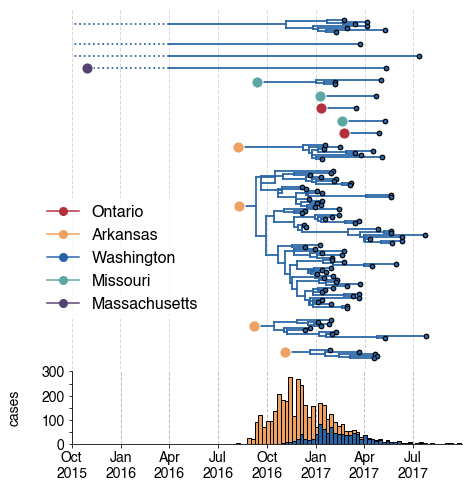

In [103]:
# run everything

metadata,node_types,node_probs = parse_leaf_and_node_traits(tree)
subtype_trees = enumerate_subtrees(tree)

group1,group2 = split_subtrees_into_plotting_groups(subtype_trees)
subtype_trees2 = order_subtrees_for_plotting(group1,group2)

# plot
plot_exploded_tree(subtype_trees2, exploded_tree_output_file_name,cutoff_value,lower_x_limit,dates_dict,7,8)  # with dotted lines
#plot_exploded_tree_no_cases(subtype_trees2, exploded_tree_output_file_name2,cutoff_value,lower_x_limit,dates_dict,10,7)  # dotted lines, no case counts

# Repeat for community/non-community

In [190]:
def plot_exploded_tree_community_status(subtype_trees2, filename, cutoff_value, lower_x_limit, dates_dict, width, height):
    
    fig,((ax1),(ax2)) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [5, 1], 'hspace':0.02}, figsize=(width, height),facecolor='w')

    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rcParams['font.size']=18

    cumulative_y=0
    axes = [ax1,ax2]
    traitName='geo'
    tipSize=20
    branchWidth=1.55 ## default branch width
    fontweight = 300 # there are 13 values here, ranging from 100-900; 400 is normal, 700 is bold
    cumulative_y=0
    cutoff = cutoff_value
    origin_size=150
    Not_Washington_color = colors['Not_Washington_color']

    dates = []
    date_labels = []
    for i in np.arange(lower_x_limit, 2018, 0.25): 
        dates.append(i)
        date_labels.append(dates_dict[i]['label'])

    for subtree in reversed(subtype_trees2['washington']): ## iterate over trait values
        origin = subtree[0]
        loc_tree = subtree[1]
        
        min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
        
        # pull out the 95% HPD for each subtree's root
        for k in loc_tree.Objects:
            if k.absoluteTime == min_node_x:
                min_node = k
        min_node_hpd = min_node.traits['height_95%_HPD']
        
        # count number of total leaves
        number_tips = 0
        for k in loc_tree.Objects:
            if k.branchType == "leaf":
                number_tips += 1
        
        """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
        for each node. Do this for all except the horizontal line connecting the origin and the subtree"""
        for k in loc_tree.Objects:
            
            xp=k.parent.absoluteTime
            x = k.absoluteTime
            y = k.y + cumulative_y
            s = tipSize
 
            if k.branchType == "leaf":
                c = colors[metadata[k.name.split("|")[0]]['community_status']]
                ax1.scatter(x,y,s=tipSize,facecolor=c, edgecolor=c,zorder=100) ## plot tip circle
                #ax1.scatter(x,y,s=tipSize,facecolor="black", edgecolor="black",zorder=99)
                              
            elif k.branchType == "node": 
                c = Not_Washington_color
                # this plots the vertical lines connecting children and parents on tree
                ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,ls='-',zorder=9)            
            
            if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
                if xp >= cutoff:
                    ax1.plot([xp,x],[y,y],lw=branchWidth,color=Not_Washington_color,ls='-',zorder=9)   # this connects horizontal tree lines
                else:
                    ax1.plot([xp,cutoff],[y,y],":",lw=branchWidth,color=Not_Washington_color,zorder=9)   # this connects horizontal tree lines
                    ax1.plot([cutoff,x],[y,y],"-",lw=branchWidth,color=Not_Washington_color,zorder=9)   # this connects horizontal tree lines

        """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
        that line be dotted or solid depending on how far back the origin is and how far back the node is"""
        # first, plot the origin circle
        oriC = colors[origin]
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
        
        # plot dotted line connecting circle to tree 
        if min_node_x < cutoff: # whole thing before cutoff, whole thing dotted
            ax1.plot([min_node_x,oriX],[oriY,oriY], ":", color=Not_Washington_color,lw=branchWidth,zorder=98)

        elif oriX < cutoff: # partly before 2016, partial dotteds
            ax1.plot([cutoff,min_node_x],[oriY,oriY],"-",color=Not_Washington_color,lw=branchWidth,zorder=98)
            ax1.plot([cutoff,oriX],[oriY,oriY],":",color=Not_Washington_color,lw=branchWidth,zorder=98)
            
        else:
            ax1.plot([min_node_x,oriX],[oriY,oriY],"-",color=Not_Washington_color,lw=branchWidth,zorder=98)
        
        # increment cumulative y displacement
        cumulative_y+=loc_tree.ySpan+5 

    # add in a legend
    han_list = []
    for key in colors_to_plot:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("_"," ").title(), markersize = 9, linestyle="None")
        han_list.append(marker)

    ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left','bottom']]

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(dates[0],dates[-1])

    ax1.axes.get_xaxis().set_ticks([])

    # in order to get the legend to plot without being transparent, over the plot, it needs to be here with frame set to true
    # bbox arguments are: x, y, with 0 being furthest left and bottom
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[-0.2, 0.15], loc=3, prop={'size': 18, 'weight':fontweight}, facecolor='w', handletextpad=0.1)


    #### CASE COUNTS ######
    dates2= []
    for d in dates: 
        string_date = dates_dict[d]['date']
        d2 = datetime.strptime(string_date, '%Y-%m-%d')
        dates2.append(d2)

    x = merged_cases['calendar_date']
    y2 = merged_cases['Marshallese_cases_WA']
    y3 = merged_cases['NonMarshallese_cases_WA']

    #ax.bar(x, y1, width=7, color="grey", edgecolor="black", bottom=y2)
    ax2.bar(x, y2, width=7, color=marshallese_color, edgecolor="black", bottom=y3)
    ax2.bar(x, y3, width=7, color=non_marshallese_color, edgecolor="black")
    ax2.xaxis_date()

    ax2.xaxis.tick_bottom()
    ax2.yaxis.tick_left()

    [ax2.spines[loc].set_visible(False) for loc in ['top','right']]

    ax2.set_xlim(str(dates2[0]),str(dates2[-1]))
    ax2.set_xticks(dates2[:-1])
    ax2.set_xticklabels(date_labels, fontsize=14)
    ax2.set_ylim(0,0)
    ax2.set_ylabel("cases", fontsize=16, weight=fontweight)
    ax2.set_yticks([0,25,50,75,100])
    ax2.set_yticklabels([0,"",50,"",100], fontsize=16, weight=fontweight)


    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [191]:
metadata_path = "../../sample-metadata-complete-2020-10-06.txt"
metadata = read_metadata(metadata_path)

In [198]:
marshallese_color = '#80AAC9'
non_marshallese_color = '#012E74'
Not_Washington_color = "#B9B9B9"

colors = {"arkansas":"#EEA160",
          "massachusetts":"#544370",
          "missouri":"#5CA7A4",
          "ontario":"#B2313D",
          "washington":"#2664A5",
         "ancestor":'grey'
          ,'Marshallese':marshallese_color, 
          'Not_Marshallese':non_marshallese_color, "Not_Washington_color":Not_Washington_color}  

colors_to_plot = ["ontario","arkansas","missouri","massachusetts",'Marshallese', 'Not_Marshallese']

/Users/lmoncla/anaconda/envs/LHM-basics/lib/python3.7/site-packages/ipykernel_launcher.py:142: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0


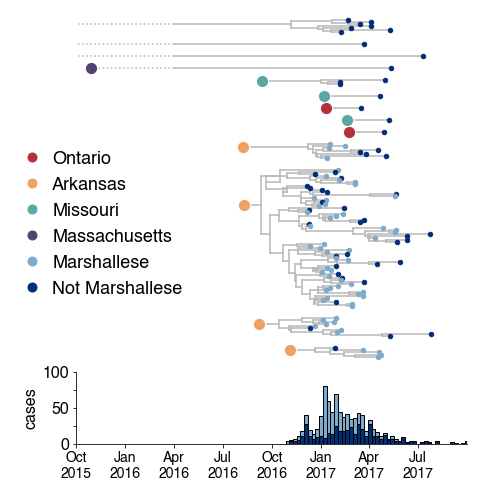

In [199]:
cutoff_value = 2016.25
lower_x_limit = 2015.75 #2016.25

filename_marshallese = output_file_directory+"full-NA-exploded-community-with-casecounts"+date+".pdf"
#filename_marshallese_wide = output_file_directory+"full-NA-exploded-community-with-casecounts-wide"+offset+date+".pdf"

plot_exploded_tree_community_status(subtype_trees2, filename_marshallese, cutoff_value, lower_x_limit, dates_dict, 7,8)
#plot_exploded_tree_no_cases_marshallese(subtype_trees2, filename_marshallese_wide, cutoff_value, lower_x_limit, dates_dict, 10,7)

# Plot for vaccination status

In [200]:
def return_vaccination_status(strain_name, metadata):
        
    if "Washington" in strain_name: 
        vaccination_status = metadata[strain_name]["vaccination_status"]
    else: 
        vaccination_status = "Not_Washington"
        
    return(vaccination_status)

In [213]:
def plot_exploded_tree_vaccination(subtype_trees2, filename, cutoff_value, lower_x_limit, dates_dict, width, height):
    
    fig,ax1 = plt.subplots(figsize=(width,height),facecolor='w')

    mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
    mpl.rcParams['font.size']=18

    cumulative_y=0
    traitName='geo'
    tipSize=25
    branchWidth=1.5 ## default branch width
    fontweight = 300 # there are 13 values here, ranging from 100-900; 400 is normal, 700 is bold
    cumulative_y=0
    cutoff = cutoff_value
    origin_size=150
    Not_Washington_color = colors['Not_Washington_color']

    # this sets the vertical dashed lines on the tree
    dates = []
    date_labels = []
    for i in np.arange(lower_x_limit, 2018, 0.25): 
        dates.append(i)
        date_labels.append(dates_dict[i]['label'])

    for subtree in reversed(subtype_trees2['washington']): ## iterate over trait values
        origin = subtree[0]
        loc_tree = subtree[1]
        min_node_x = min(k.absoluteTime for k in loc_tree.Objects)
        
        # pull out the 95% HPD for each subtree's root
        for k in loc_tree.Objects:
            if k.absoluteTime == min_node_x:
                min_node = k
        min_node_hpd = min_node.traits['height_95%_HPD']
        
        # count number of total leaves
        number_tips = 0
        for k in loc_tree.Objects:
            if k.branchType == "leaf":
                number_tips += 1
        
        """ Iterate through each object in the subtree, and plot a dot for each tip, and lines connecting them
        for each node. Do this for all except the horizontal line connecting the origin and the subtee"""
        for k in loc_tree.Objects:
            
            xp=k.parent.absoluteTime
            x = k.absoluteTime
            y = k.y + cumulative_y
            s = tipSize
 
            if k.branchType == "leaf":
                c = colors[metadata[k.name.split("|")[0]]['vaccination_status']]
                ax1.scatter(x,y,s=tipSize,facecolor=c, edgecolor=c,zorder=100) ## plot tip circle
                #ax1.scatter(x,y,s=tipSize,facecolor="black", edgecolor="black",zorder=99)
                              
            elif k.branchType == "node": 
                c = Not_Washington_color
                # this plots the vertical lines connecting children and parents on tree
                ax1.plot([x,x],[k.children[-1].y + cumulative_y,k.children[0].y+ cumulative_y],lw=branchWidth,color=c,ls='-',zorder=9)            
            
            if xp != loc_tree.root.absoluteTime:  # don't plot line connecting subtree to origin
                if xp >= cutoff:
                    ax1.plot([xp,x],[y,y],lw=branchWidth,color=Not_Washington_color,ls='-',zorder=9)   # this connects horizontal tree lines
                else:
                    ax1.plot([xp,cutoff],[y,y],":",lw=branchWidth,color=Not_Washington_color,zorder=9)   # this connects horizontal tree lines
                    ax1.plot([cutoff,x],[y,y],"-",lw=branchWidth,color=Not_Washington_color,zorder=9)   # this connects horizontal tree lines

        """ Plot a colored circle at the origin, and plot a line connecting that circle to the subtree. Make 
        that line be dotted or solid depending on how far back the origin is and how far back the node is"""
        # first, plot the origin circle
        oriC = colors[origin]
        if loc_tree.root.absoluteTime==None:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        else:
            oriX=loc_tree.root.absoluteTime
            oriY=loc_tree.root.y+cumulative_y
        ax1.scatter(oriX,oriY,s=origin_size,facecolor=oriC,edgecolor='w',lw=1,zorder=200) ## add big circle at base of tree to indicate origin
                
        # plot dotted line connecting circle to tree 
        if min_node_x < cutoff: # whole thing before cutoff, whole thing dotted
            ax1.plot([min_node_x,oriX],[oriY,oriY], ":", color=Not_Washington_color,lw=branchWidth,zorder=98)

        elif oriX < cutoff: # partly before 2016, partial dotteds
            ax1.plot([min_node_x,cutoff],[oriY,oriY],"-",color=Not_Washington_color,lw=branchWidth,zorder=98)
            ax1.plot([cutoff,oriX],[oriY,oriY],":",color=Not_Washington_color,lw=branchWidth,zorder=98)

        else:
            ax1.plot([min_node_x,oriX],[oriY,oriY],"-",color=Not_Washington_color,lw=branchWidth,zorder=98)
        
        # increment cumulative y displacement
        cumulative_y+=loc_tree.ySpan+5 

    #add in a legend
    han_list = []
    for key in colors_to_plot:
        marker = mlines.Line2D(range(1), range(1), color = colors[key], marker='o', markerfacecolor = colors[key], label = key.replace("up_to_date","up-to-date").replace("_"," ").title(), markersize = 8)
        han_list.append(marker)
    ax1.legend(handles = han_list, markerfirst = True, edgecolor="white", bbox_to_anchor=[-0.2, 0.1], loc=3, prop={'size': 16, 'weight':fontweight}, facecolor='w')
    #lgd = ax.legend(handles = han_list, markerfirst = True, frameon=True, edgecolor="white", bbox_to_anchor=[0.9, 0.15], loc=3, prop={'size': 16}, title=legend_title, title_fontsize=16)

    ax1.xaxis.tick_bottom()
    ax1.yaxis.tick_left()

    [ax1.spines[loc].set_visible(False) for loc in ['top','right','left']] #,'bottom'

    ax1.tick_params(axis='y',size=0)
    ax1.set_yticklabels([])
    ax1.set_ylim(-5,cumulative_y)
    ax1.set_xlim(dates[0],dates[-1])
    ax1.set_xticks(dates[:-1])
    ax1.set_xticklabels(date_labels, fontsize=16,weight=fontweight)
    
    plt.savefig(filename,bbox_inches = 'tight',pad_inches = 0)
    plt.show()

In [214]:
vaccinated_color = '#73B387'
unvaccinated_color =  '#CDD2A0'
unknown_vacc_color = '#0E2D1E'

Not_Washington_color = "#B9B9B9"

colors = {"arkansas":"#EEA160",
          "massachusetts":"#544370",
          "missouri":"#5CA7A4",
          "ontario":"#B2313D",
          "washington":"#2664A5",
         "ancestor":'grey',
          'up_to_date':vaccinated_color,
          'not_up_to_date':unvaccinated_color, 'unknown':unknown_vacc_color,
          "Not_Washington_color":Not_Washington_color}  
colors_to_plot = ["ontario","arkansas","missouri","massachusetts",'up_to_date', 'not_up_to_date',"unknown"]

In [215]:
vacc_tree_filename = output_file_directory+"full-NA-exploded-vaccination"+date+".pdf"
metadata_path = "../../sample-metadata-complete-2020-10-06.txt"
metadata = read_metadata(metadata_path)

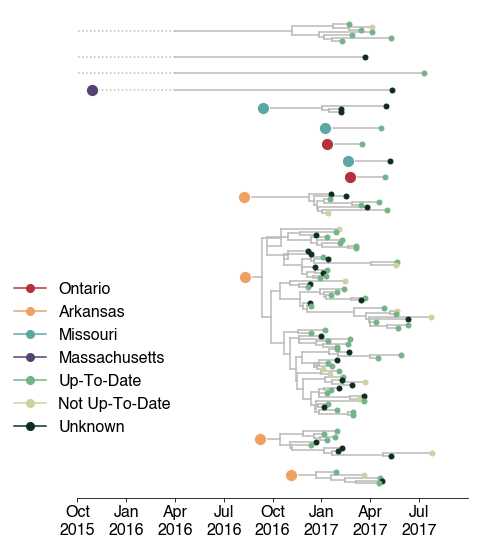

In [216]:
cutoff_value = 2016.25
lower_x_limit = 2015.75

plot_exploded_tree_vaccination(subtype_trees2, vacc_tree_filename, cutoff_value, lower_x_limit, dates_dict, 7,9)